In [201]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [202]:
import pandas as pd
#raw = pd.pandas.read_csv('20170101_raw.csv',sep=";")
raw = pd.pandas.read_csv('20180608_raw_geo.csv',sep=",",low_memory=False)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy import stats
print("imported " + str(len(raw)) + " rows")
#raw.columns.tolist()

imported 60503 rows


In [203]:
##############################
####    var cleaning     #####
##############################
input = ['living_area','sold_price']
clean = raw
clean = clean[pd.notnull(raw[input]).all(axis=1)] #rowsum booleans for nullvals in col
#clean = raw[pd.notnull(raw['living_area']) & pd.notnull(raw['rooms']) & pd.notnull(raw['floor']) & pd.notnull(raw['sold_price']) & pd.notnull(raw['min_distance_to_metro'])]
print("Removed " +str(len(raw)-len(clean)) + " rows with nulls")


##############################
#### additional features #####
##############################
sqm_price =  pd.DataFrame({'sqm_price':clean.sold_price / clean.living_area}) 
sqm_rent =  pd.DataFrame({'sqm_rent':clean.rent / clean.living_area})
clean = pd.concat([clean , sqm_price, sqm_rent], axis=1)

# time features
#https://pandas.pydata.org/pandas-docs/stable/timeseries.html
datetime =  pd.DataFrame({'datetime': pd.to_datetime(clean['sold_date'])})
clean = pd.concat([clean , datetime], axis=1)

year = pd.DataFrame({'year': clean['datetime'].dt.year})
month_nbr = pd.DataFrame({'month_nbr': clean['datetime'].dt.month})
year_month = pd.DataFrame({'year_month': clean['datetime'].dt.to_period('M')})
def get_week(row): return row['datetime'].isocalendar()[1]
week = pd.DataFrame({'week': clean.apply(get_week, axis=1)})


clean = pd.concat([clean , year,month_nbr,year_month, week], axis=1)

##############################
####   remove outliers   #####
##############################
#remove june 2018 transactions
clean = clean[clean.datetime < '2018-06-01']

num = len(clean)
before = num
important_vars = ['living_area','floor','sqm_price','distance_ocean','sqm_rent','construction_year']
for i in important_vars:
    q_u = clean[i].quantile(0.995)
    q_l = clean[i].quantile(0.005)
    clean = clean[(clean[i] < q_u) | (pd.isnull(clean[i]))]
    clean = clean[(clean[i] > q_l) | (pd.isnull(clean[i]))]
    print(str(q_l) + " < " + i + " < " + str(q_u) + ". " + str(num - len(clean)) + " removed.")
    num = len(clean)
print("bedore: " + str(before) + ", after: " + str(len(clean)))

Removed 145 rows with nulls
19.5 < living_area < 174.98199999999997. 613 removed.
0.0 < floor < 12.0. 2071 removed.
29378.029523528152 < sqm_price < 130569.16099773231. 574 removed.
198.0 < distance_ocean < 7560.690000000002. 526 removed.
14.393769440741448 < sqm_rent < 87.67234576757527. 552 removed.
1879.0 < construction_year < 2017.0. 769 removed.
bedore: 60037, after: 54932


## Variable Plot

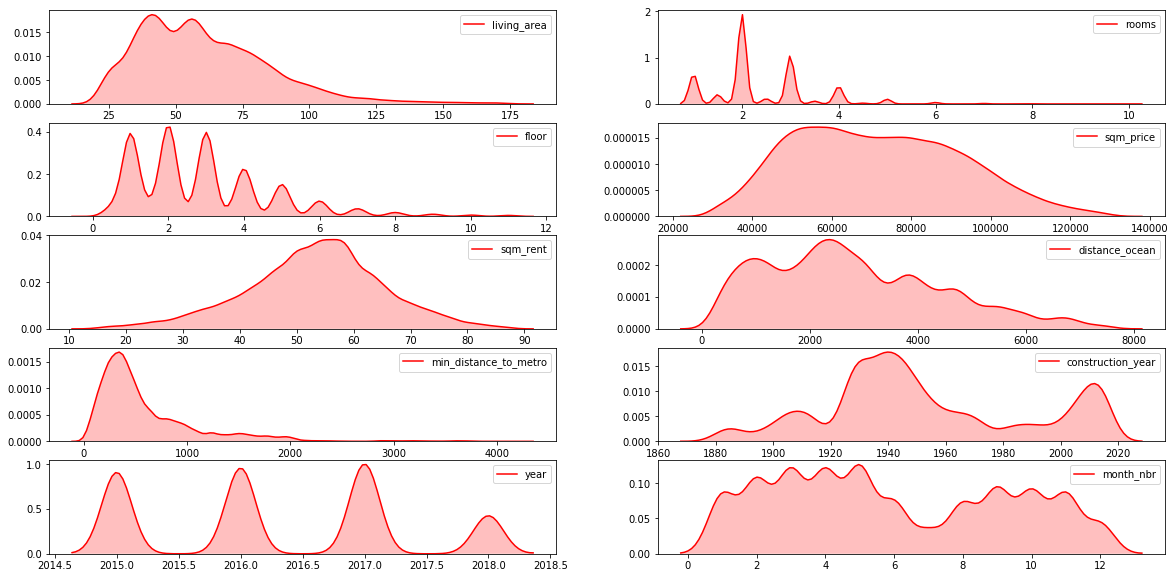

In [204]:
plot_vars = ['living_area','rooms','floor','sqm_price','sqm_rent','distance_ocean','min_distance_to_metro','construction_year','year','month_nbr']

plt.subplots(figsize=(20,10))
for i in range(1,len(plot_vars)+1):
    data = clean[pd.notnull(clean[plot_vars[i-1]])][plot_vars[i-1]] # remove null values for the var plot
    plt.subplot(math.ceil(len(plot_vars)/2),2,i)
    sns.kdeplot(data,shade=True, color="r", bw='scott')#bw=math.sqrt(len(clean[plot_vars[i-1]].unique()))/10)

plt.show()

## Timeseries Plots

In [205]:
##define plot function and top 10 areas

#http://pandas.pydata.org/pandas-docs/version/0.16.2/generated/pandas.core.groupby.DataFrameGroupBy.plot.html
def timeseries_plot(plot_data,title):
    plt.plot(plot_data)
    plt.title(title)
    plt.ylabel('Sqm Price')
    plt.xlabel('Month')
    plt.legend(list(plot_data.columns.values))
    
areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values

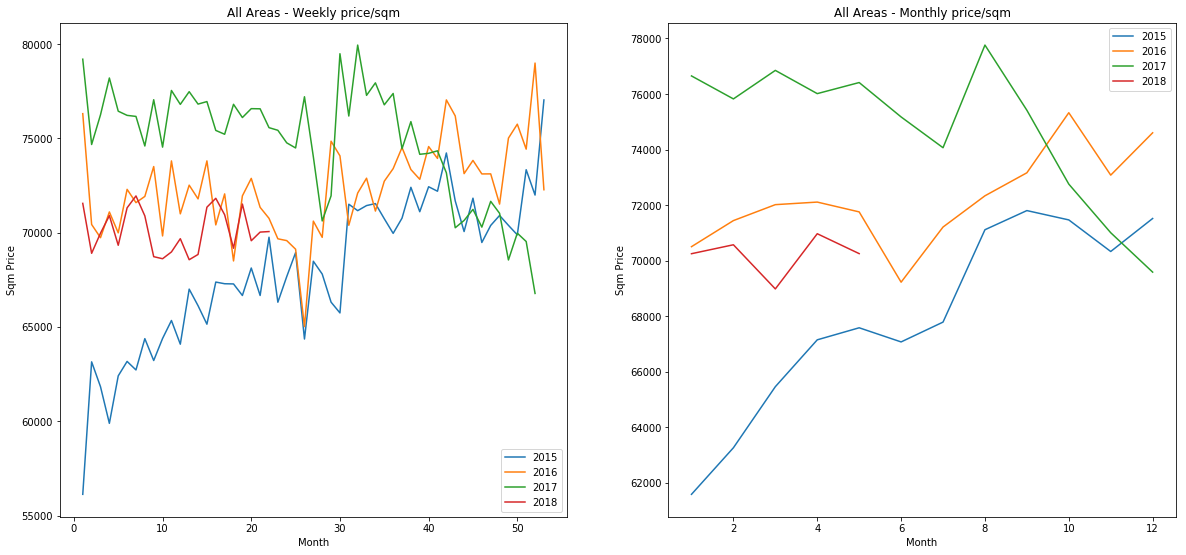

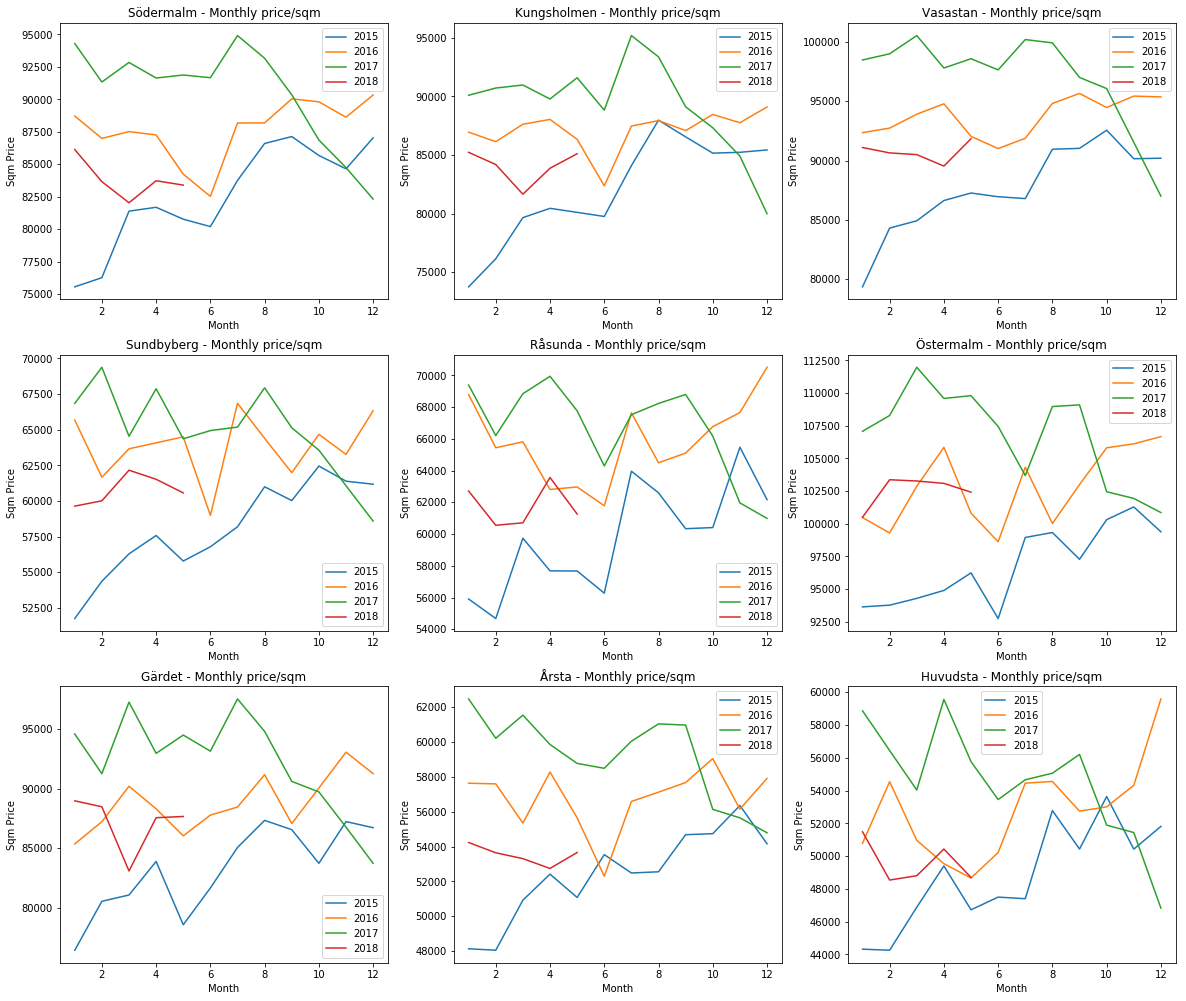

In [206]:
plt.subplots(figsize=(20,20))
plt.subplot(2,2,1)
timeseries_plot(clean.groupby(['week','year']).mean()['sqm_price'].unstack(),"All Areas - Weekly price/sqm")
plt.subplot(2,2,2)
timeseries_plot(clean.groupby(['month_nbr','year']).mean()['sqm_price'].unstack(),"All Areas - Monthly price/sqm")


areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
plt.subplots(figsize=(20,60))
for i in range(0,len(areas)):
    plt.subplot(10,3,i+1)
    plot_data = clean[(clean.area_from_geo == areas[i])].groupby(['month_nbr','year']).mean()['sqm_price'].unstack()
    timeseries_plot(plot_data, areas[i] + " - Monthly price/sqm")
    
plt.show()



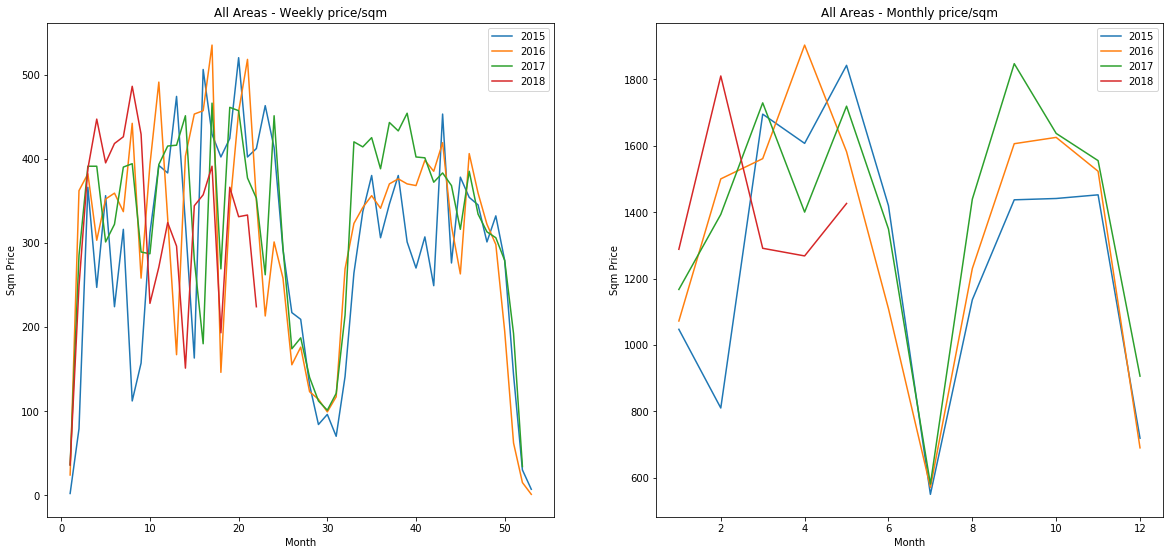

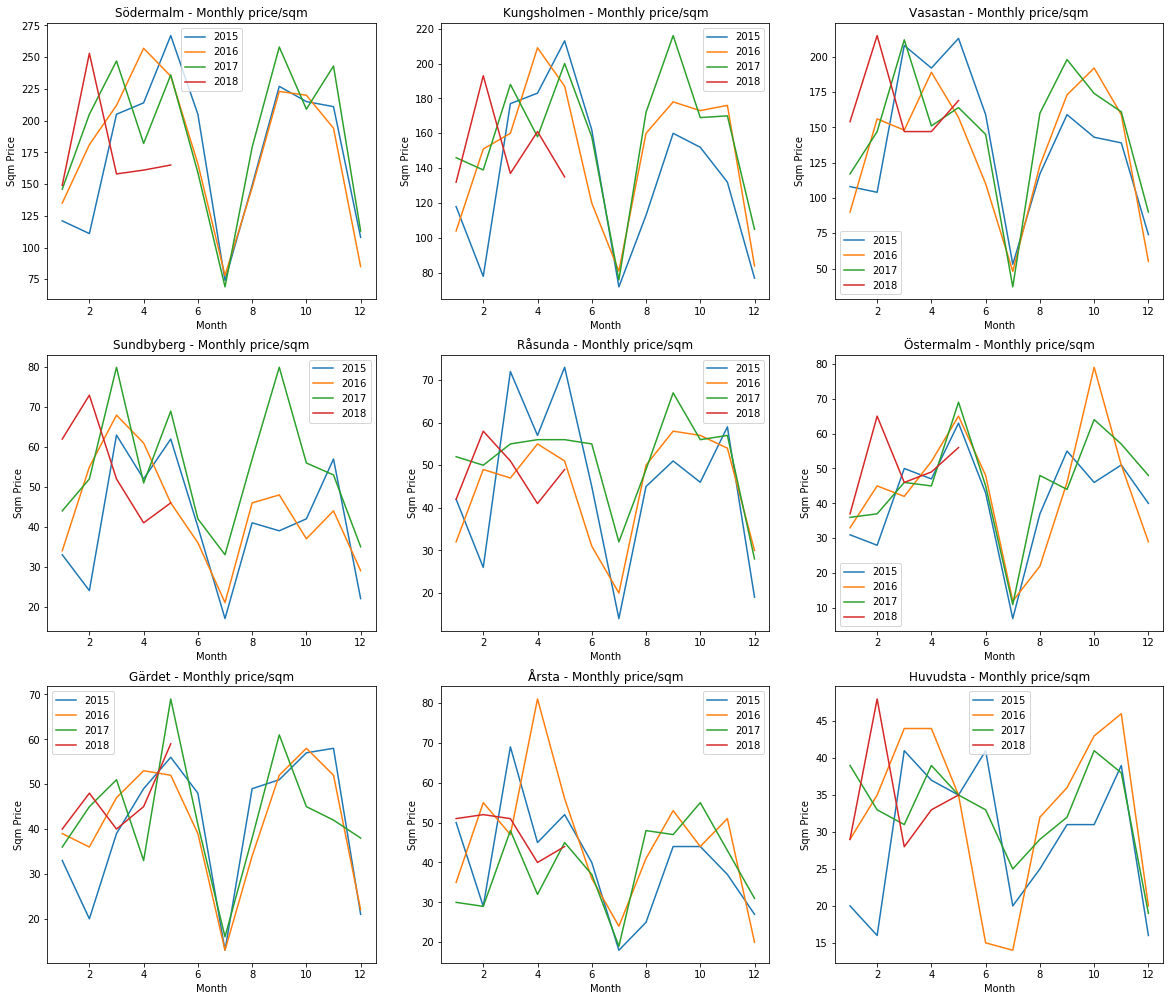

In [207]:
plt.subplots(figsize=(20,20))
plt.subplot(2,2,1)
timeseries_plot(clean.groupby(['week','year']).count()['sqm_price'].unstack(),"All Areas - Weekly num sold")
plt.subplot(2,2,2)
timeseries_plot(clean.groupby(['month_nbr','year']).count()['sqm_price'].unstack(),"All Areas - Monthlynum sold")


areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
plt.subplots(figsize=(20,60))
for i in range(0,len(areas)):
    plt.subplot(10,3,i+1)
    plot_data = clean[(clean.area_from_geo == areas[i])].groupby(['month_nbr','year']).count()['sqm_price'].unstack()
    timeseries_plot(plot_data, areas[i] + " - Monthly num sold")
    
plt.show()



## Box Plots


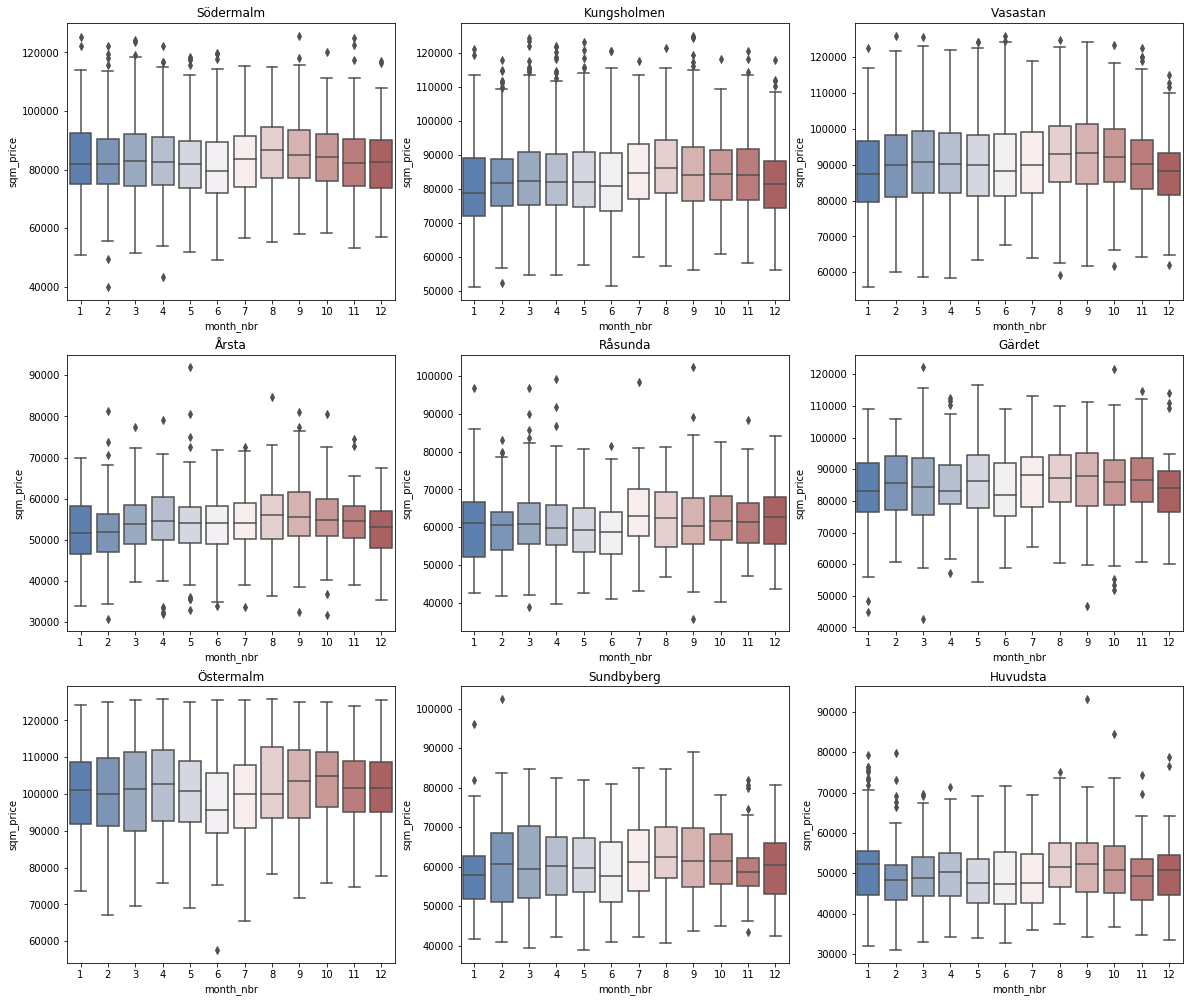

In [685]:
# top 10 areas:
areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
#print(hej)
plt.subplots(figsize=(20,60))
for i in range(0,len(areas)):
    plt.subplot(10,3,i+1)
    sns.boxplot(x="month_nbr", y="sqm_price", data=clean[(clean.area_from_geo == areas[i])] ,palette="vlag").set_title(areas[i])

plt.show()



## Bivariate Plot

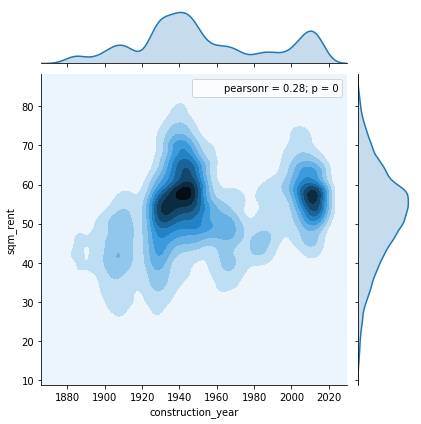

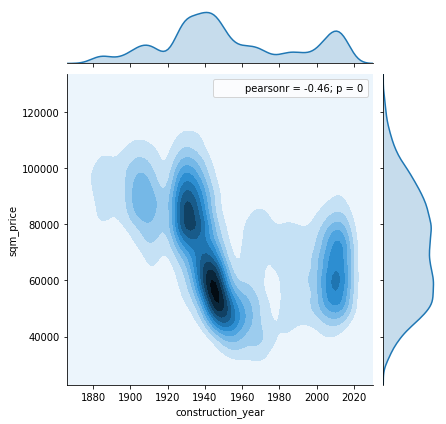

In [109]:



## contruction year vs (price/rent)
sns.jointplot(x="construction_year", y="sqm_rent", data=clean, kind="kde");
sns.jointplot(x="construction_year", y="sqm_price", data=clean, kind="kde");

#sns.jointplot(x="sqm_rent", y="sqm_price", data=clean, kind="kde");
#sns.jointplot(x="min_distance_to_metro", y="sqm_price", data=clean, kind="kde");
plt.show()

# not so nice
#sns.jointplot(x="month_nbr", y="sqm_price", data=clean, kind="kde");

area_from_geo
Södermalm           7957
Kungsholmen         6439
Vasastan            6291
Östermalm           2464
Råsunda             2146
Sundbyberg          2083
Gärdet              1831
Årsta               1796
Huvudsta            1414
Hammarbyhamnen      1237
Liljeholmen         1158
Midsommarkransen    1143
Hammarbyhöjden      1134
Hagalund            1061
Mariehäll            948
Järva                927
Fruängen             920
Ursta                820
Aspudden             812
Globen               743
dtype: int64


area_from_geo
Södermalm           7372
Kungsholmen         6075
Vasastan            5857
Sundbyberg          1943
Råsunda             1937
Östermalm           1825
Gärdet              1738
Årsta               1725
Huvudsta            1312
Hammarbyhamnen      1155
Midsommarkransen    1077
Liljeholmen         1064
Hammarbyhöjden      1057
Hagalund             989
Mariehäll            882
Järva                852
Aspudden             778
Ursta                732
Globen               697
Gamla Enskede        663
dtype: int64